In [1]:
!pip install -q tensorflow
!pip install -q protobuf


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 14.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 requires pyOpenSSL<=24.2.1,>=19.1.0, but you have pyopenssl 25.3.0 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2025.10.0 w

In [2]:
import os
import zipfile
import random
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, layers, models
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt



2025-11-08 20:18:02.715471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762633082.916427      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762633082.973280      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Connection au Drive et selection des images aux hasard

In [3]:


base = "/kaggle/input/dogs-vs-cats-redux-kernels-edition"
print("📂 Contenu du dossier de base :", os.listdir(base))

train_zip = os.path.join(base, "train.zip")
test_zip = os.path.join(base, "test.zip")

train_extract_path = "/kaggle/working/train"
test_extract_path = "/kaggle/working/test"

# Décompression train.zip
if not os.path.exists(train_extract_path) or len(os.listdir(train_extract_path)) == 0:
    print("📦 Extraction de train.zip...")
    with zipfile.ZipFile(train_zip, 'r') as zip_ref:
        zip_ref.extractall(train_extract_path)
    print("✅ train.zip décompressé avec succès")

# Décompression test.zip
if not os.path.exists(test_extract_path) or len(os.listdir(test_extract_path)) == 0:
    print("📦 Extraction de test.zip...")
    with zipfile.ZipFile(test_zip, 'r') as zip_ref:
        zip_ref.extractall(test_extract_path)
    print("✅ test.zip décompressé avec succès")

# 🔍 Vérifie la vraie structure du dossier
print("\n📁 Contenu de /kaggle/working/train :", os.listdir(train_extract_path))
print("📁 Contenu de /kaggle/working/test :", os.listdir(test_extract_path))

# 📸 Corrige le chemin s’il y a un sous-dossier "train" à l’intérieur
if "train" in os.listdir(train_extract_path):
    train_dir = os.path.join(train_extract_path, "train")
else:
    train_dir = train_extract_path

if "test" in os.listdir(test_extract_path):
    test_dir = os.path.join(test_extract_path, "test")
else:
    test_dir = test_extract_path

# Vérification finale
print("\n📸 Exemples de fichiers dans train :", os.listdir(train_dir)[:10])
print("📸 Exemples de fichiers dans test :", os.listdir(test_dir)[:10])


📂 Contenu du dossier de base : ['sample_submission.csv', 'train.zip', 'test.zip']
📦 Extraction de train.zip...
✅ train.zip décompressé avec succès
📦 Extraction de test.zip...
✅ test.zip décompressé avec succès

📁 Contenu de /kaggle/working/train : ['train']
📁 Contenu de /kaggle/working/test : ['test']

📸 Exemples de fichiers dans train : ['cat.4649.jpg', 'dog.8326.jpg', 'dog.284.jpg', 'cat.8146.jpg', 'dog.3932.jpg', 'dog.1840.jpg', 'dog.11232.jpg', 'cat.11162.jpg', 'cat.347.jpg', 'cat.9636.jpg']
📸 Exemples de fichiers dans test : ['2993.jpg', '8064.jpg', '1162.jpg', '179.jpg', '369.jpg', '800.jpg', '10499.jpg', '839.jpg', '8883.jpg', '7360.jpg']


In [4]:
noms_fichiers = os.listdir(train_dir)
noms_fichiers

['cat.4649.jpg',
 'dog.8326.jpg',
 'dog.284.jpg',
 'cat.8146.jpg',
 'dog.3932.jpg',
 'dog.1840.jpg',
 'dog.11232.jpg',
 'cat.11162.jpg',
 'cat.347.jpg',
 'cat.9636.jpg',
 'dog.6688.jpg',
 'dog.11311.jpg',
 'dog.7824.jpg',
 'cat.7415.jpg',
 'dog.10827.jpg',
 'dog.11588.jpg',
 'dog.10243.jpg',
 'dog.3808.jpg',
 'cat.5326.jpg',
 'dog.2856.jpg',
 'cat.3348.jpg',
 'cat.6559.jpg',
 'cat.2671.jpg',
 'cat.3379.jpg',
 'cat.7359.jpg',
 'dog.7962.jpg',
 'cat.421.jpg',
 'dog.2128.jpg',
 'cat.6124.jpg',
 'dog.7226.jpg',
 'dog.9464.jpg',
 'dog.5354.jpg',
 'cat.10965.jpg',
 'cat.6997.jpg',
 'dog.11731.jpg',
 'dog.8750.jpg',
 'dog.10605.jpg',
 'dog.809.jpg',
 'cat.9619.jpg',
 'cat.1076.jpg',
 'cat.3174.jpg',
 'cat.7199.jpg',
 'dog.10886.jpg',
 'dog.8619.jpg',
 'cat.9839.jpg',
 'cat.3255.jpg',
 'cat.9745.jpg',
 'cat.11571.jpg',
 'cat.1154.jpg',
 'cat.6823.jpg',
 'cat.5914.jpg',
 'dog.692.jpg',
 'cat.450.jpg',
 'cat.2858.jpg',
 'dog.5075.jpg',
 'dog.11669.jpg',
 'dog.7156.jpg',
 'cat.4204.jpg',
 'cat.72

In [5]:
# Initialiser une liste pour les catégories
categories = []

# Boucle pour assigner les catégories
for filename in noms_fichiers:
    # Obtenir la partie avant le premier point du nom de fichier
    categorie = filename.split('.')[0]
    # Vérifier si cette partie est "dog"
    if categorie == 'dog':
        # Ajouter 1 à la liste categories (indiquant que c'est une image de chien)
        categories.append(1)
    else:
        # Ajouter 0 à la liste categories (indiquant que c'est une image de chat)
        categories.append(0)

In [6]:
categories

[0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,


In [7]:
# creer un dataframe avec pandas

df = pd.DataFrame ({
    'filename': noms_fichiers,
    'categorie': categories
})

# Afficher le dataframe
print(df.head())

       filename  categorie
0  cat.4649.jpg          0
1  dog.8326.jpg          1
2   dog.284.jpg          1
3  cat.8146.jpg          0
4  dog.3932.jpg          1


In [8]:
compte_categories = df["categorie"].value_counts()
noms_categories = ["chien", "chat"]
compte_categories

categorie
0    12500
1    12500
Name: count, dtype: int64

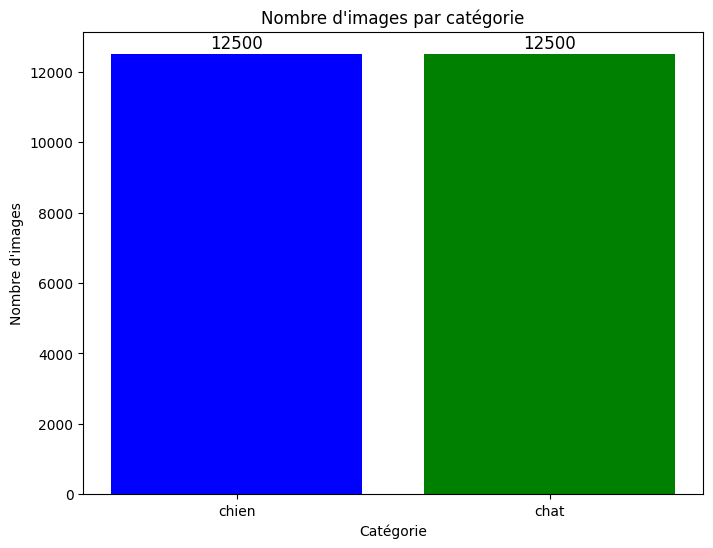

In [9]:
plt.figure(figsize=(8, 6))
couleurs = ['blue', 'green']  # Couleurs compréhensibles
plt.bar(noms_categories, compte_categories, color=couleurs)
plt.xlabel('Catégorie')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par catégorie')
for i, v in enumerate(compte_categories):
    plt.text(i, v + 50, str(v), ha='center', va='bottom', fontsize=12, color='black')

In [10]:
# Sélectionner une image aléatoire
# Sélectionner une image aléatoire
image_aleatoire = random.choice(noms_fichiers)


# Chemin complet de l'image sélectionnée
img_path = os.path.join(train_dir, image_aleatoire)
img_path

'/kaggle/working/train/train/dog.10033.jpg'

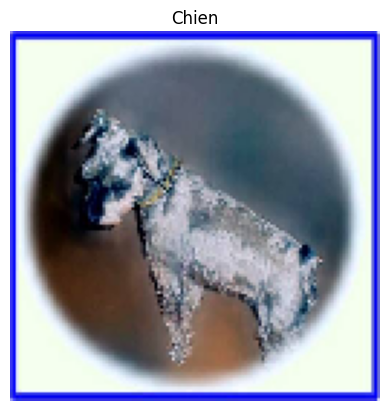

In [11]:
# Charger et afficher l'image
img = image.load_img(img_path, target_size=(128, 128))
plt.imshow(img)
categorie = 'Chien' if 'dog' in image_aleatoire else 'Chat'
plt.title(categorie)
plt.axis('off')
plt.show()

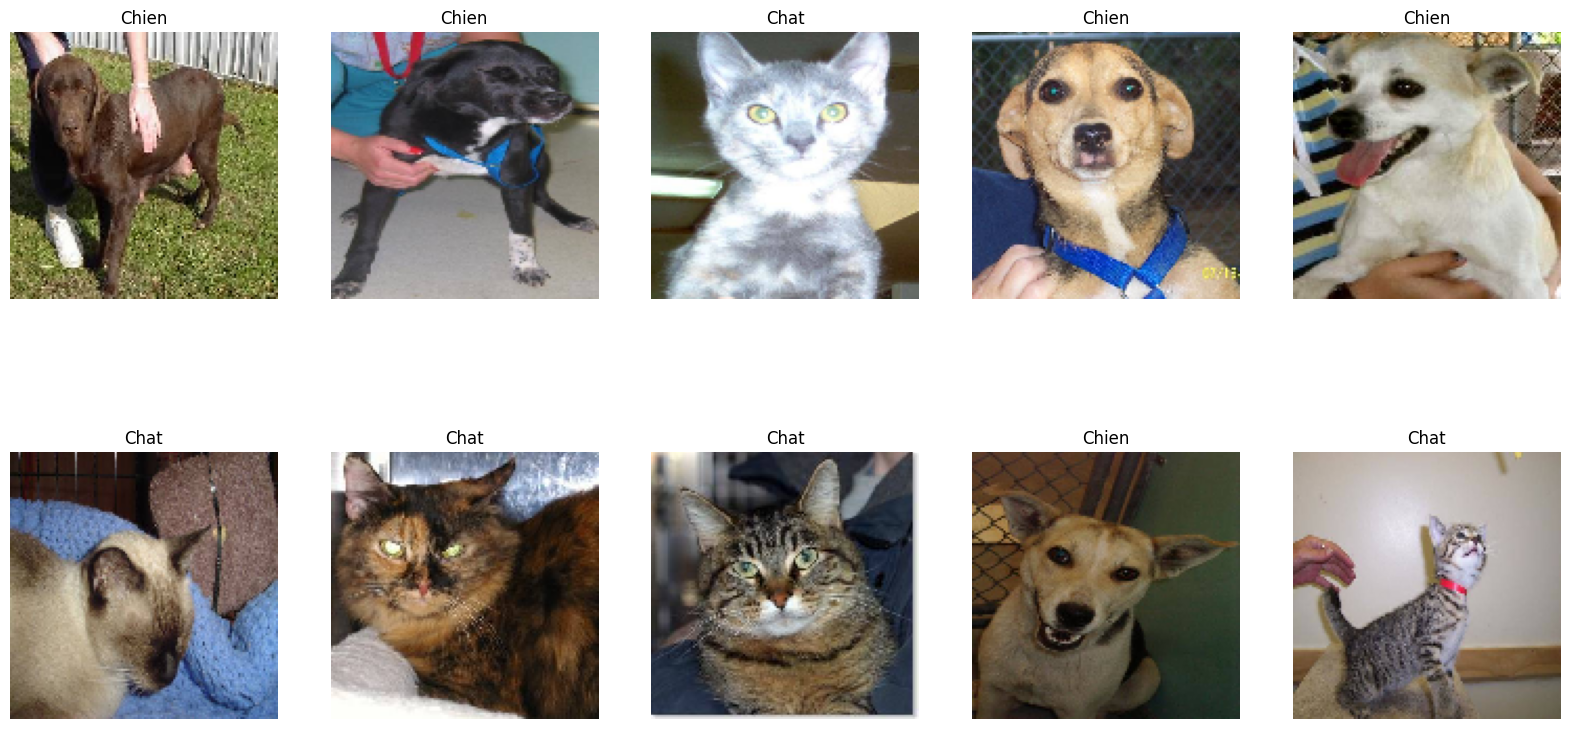

In [12]:
# Sélectionner 10 images aléatoires
random_images = df.sample(n=10)

# Afficher les 10 images aléatoires
plt.figure(figsize=(20, 10))

for i, row in enumerate(random_images.iterrows()):
    filename = row[1]['filename']
    category = 'Chien' if row[1]['categorie'] == 1 else 'Chat'
    img_path = os.path.join(train_dir, filename)
    img = image.load_img(img_path, target_size=(128, 128))
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis('off')

plt.show()

# Construction du model

In [13]:
# Sélectionner aléatoirement 1500 images de chats (catégorie 0)
chats_df = df[df['categorie'] == 0].sample(n=1500, random_state=42)

# Sélectionner aléatoirement 1500 images de chiens (catégorie 1)
chiens_df = df[df['categorie'] == 1].sample(n=1500, random_state=42)

# Combiner les deux DataFrames
df_final = pd.concat([chats_df, chiens_df]).reset_index(drop=True)
df_final

filename  categorie
0      cat.7639.jpg          0
1      cat.1611.jpg          0
2      cat.6797.jpg          0
3     cat.12182.jpg          0
4      cat.3433.jpg          0
...             ...        ...
2995   dog.3547.jpg          1
2996  dog.11512.jpg          1
2997  dog.12054.jpg          1
2998  dog.12242.jpg          1
2999  dog.11651.jpg          1

[3000 rows x 2 columns]

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255, # Ré-échelle les valeurs des pixels entre 0 et 255 à l'intervalle 0,1
    validation_split=0.2, # 20% des données pour la validation
)

In [15]:
# S'assurer que la colonne 'category' contient des chaînes de caractères
df_final['categorie'] = df_final['categorie'].astype(str)

# Générateur pour les données d'entraînement
train_generator = train_datagen.flow_from_dataframe(
    df_final,
    train_dir,
    x_col='filename',
    y_col='categorie',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'  # Utiliser les données d'entrainnement
)

Found 2400 validated image filenames belonging to 2 classes.


In [16]:
# Générateur pour les données de validation
validation_generator = train_datagen.flow_from_dataframe(
    df_final,
    train_dir,
    x_col='filename',
    y_col='categorie',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Utiliser les données de validation
)

Found 600 validated image filenames belonging to 2 classes.


Taille du lot de données : (32, 150, 150, 3)
Taille du lot d'étiquettes : (32,)


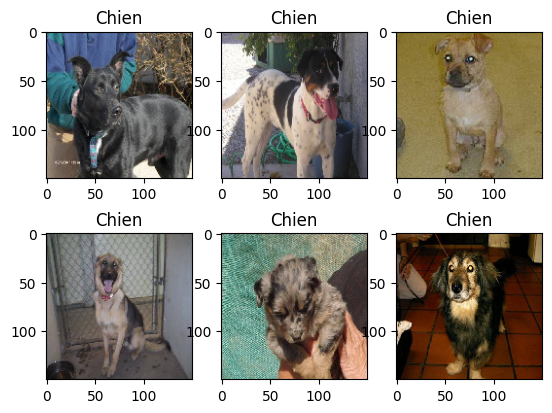

In [17]:
for data_batch, labels_batch in train_generator:
    print("Taille du lot de données :", data_batch.shape)  # Affiche la forme du lot de données
    print("Taille du lot d'étiquettes :", labels_batch.shape)  # Affiche la forme du lot d'étiquettes
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(data_batch[i])  # Affiche l'image prétraitée
        plt.title("Chat" if labels_batch[i] == 0 else "Chien")  # Titre en fonction de l'étiquette
    plt.show()
    break  # Affiche un seul lot d'images

In [18]:
model = models.Sequential()

# Ajouter les couches une par une

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))  # Couche de convolution : 32 filtres de 3x3, détecte des motifs simples dans l'image, ReLU pour rendre le modèle non-linéaire, forme d'entrée (150x150x3).

model.add(layers.MaxPooling2D((2, 2)))  # Couche de max pooling : réduit les dimensions de l'image en prenant le maximum de chaque carré de 2x2 pixels.

model.add(layers.Conv2D(64, (3, 3), activation='relu'))  # Deuxième couche de convolution : 64 filtres de 3x3, détecte des motifs plus complexes, ReLU pour l'activation.

model.add(layers.MaxPooling2D((2, 2)))  # Deuxième couche de max pooling : réduit encore les dimensions de l'image.

model.add(layers.Flatten())  # Couche Flatten : transforme les données 2D en un vecteur 1D pour la couche dense suivante.

model.add(layers.Dense(512, activation='relu'))  # Couche dense (fully connected) : 512 neurones, chaque neurone est connecté à tous les neurones de la couche précédente, ReLU pour l'activation.

model.add(layers.Dense(1, activation='sigmoid'))  # Couche de sortie : 1 neurone, activation sigmoïde pour produire une probabilité entre 0 et 1, utilisée pour la classification binaire (chat ou chien).


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1762633115.218617      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    42,467,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,487,745 (162.08 MB)

 Trainable params: 42,487,745 (162.08 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
optimi = optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=optimi,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
# Entraînement du modèle et sauvegarde de l'historique d'entraînement dans 'history'
history = model.fit(
    train_generator,  # Utilise le générateur pour les données d'entraînement

    # Le nombre d'étapes (batches) à exécuter à chaque époque.
    # Calculé comme le nombre total d'échantillons d'entraînement divisé par la taille du lot.
    steps_per_epoch=train_generator.samples // train_generator.batch_size,

    epochs=30,  # Nombre total d'époques pour l'entraînement

    validation_data=validation_generator,  # Utilise le générateur pour les données de validation

    # Le nombre d'étapes (batches) à exécuter pour chaque époque de validation.
    # Calculé comme le nombre total d'échantillons de validation divisé par la taille du lot.
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1762633117.817543     121 service.cc:148] XLA service 0x785e300033d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762633117.818289     121 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762633118.080859     121 cuda_dnn.cc:529] Loaded cuDNN version 90300


 5/75 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5542 - loss: 1.0631

I0000 00:00:1762633120.522556     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.6137 - loss: 0.7531 - val_accuracy: 0.0000e+00 - val_loss: 1.2654
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.6358 - loss: 0.6455 - val_accuracy: 0.3403 - val_loss: 0.7823
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.6563 - loss: 0.6053 - val_accuracy: 0.2917 - val_loss: 0.8257
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.6913 - loss: 0.5857 - val_accuracy: 0.2622 - val_loss: 0.9079
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.7063 - loss: 0.5740 - val_accuracy: 0.1892 - val_loss: 1.0198
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.6927 - loss: 0.5597 - val_accuracy: 0.2483 - val_loss: 0.9911
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.7237 - loss: 0.5341 - val_accuracy: 0.2188 - val_loss: 1.0567
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.7510 - loss: 0.5013 - val_accuracy: 0.4913 - val_loss

In [22]:
# Évaluer les performances du modèle sur la base de validation
validation_steps = validation_generator.samples // validation_generator.batch_size
evaluation = model.evaluate(validation_generator, steps=validation_steps)

# Afficher les résultats de l'évaluation
print(f"Perte sur la validation: {evaluation[0]}")
print(f"Précision sur la validation: {evaluation[1]}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6147 - loss: 1.0392
Perte sur la validation: 1.257898211479187
Précision sur la validation: 0.5607638955116272


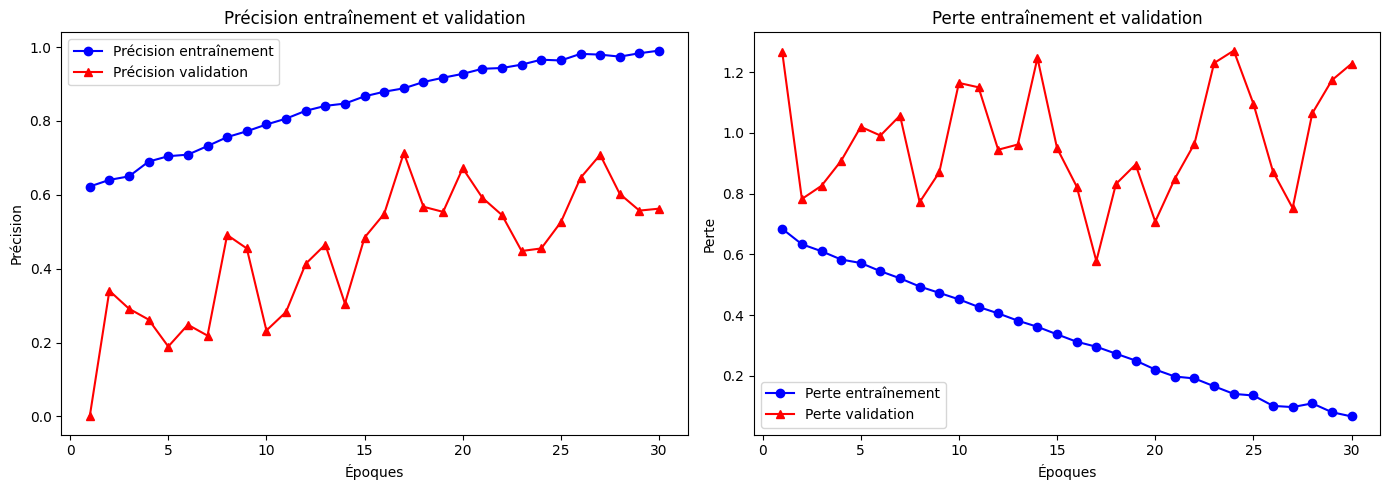

In [23]:

# Récupérer les données de l'historique
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


# Tracer la courbe de précision
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Précision entraînement')  # 'bo-' : bleu avec des points et lignes
plt.plot(epochs, val_acc, 'r^-', label='Précision validation')  # 'r^-' : rouge avec des triangles et lignes
plt.title('Précision entraînement et validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

# Tracer la courbe de perte
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Perte entraînement')  # 'bo-' : bleu avec des points et lignes
plt.plot(epochs, val_loss, 'r^-', label='Perte validation')  # 'r^-' : rouge avec des triangles et lignes
plt.title('Perte entraînement et validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
from keras.models import load_model

# Chemin où vous voulez sauvegarder votre modèle
save_path = '/content/drive/MyDrive/dogs-vs-cats/cats_and_dogs_model.h5'

# Supposons que 'model' est votre modèle que vous avez entraîné
model.save(save_path)

print(f"Modèle sauvegardé à l'emplacement : {save_path}")

Modèle sauvegardé à l'emplacement : /content/drive/MyDrive/dogs-vs-cats/cats_and_dogs_model.h5


In [25]:
from keras.utils import load_img, img_to_array

# Charger le modèle sauvegardé
model = load_model('/content/drive/MyDrive/dogs-vs-cats/cats_and_dogs_model.h5')

# Sélectionner aléatoirement 10 images de chats (catégorie 0)
chats_df = df[df['categorie'] == 0].sample(n=10, random_state=42)

# Sélectionner aléatoirement 10 images de chiens (catégorie 1)
chiens_df = df[df['categorie'] == 1].sample(n=10, random_state=42)

# Combiner les deux DataFrames
df_final = pd.concat([chats_df, chiens_df]).reset_index(drop=True)

# S'assurer que la colonne 'category' contient des chaînes de caractères
df_final['categorie'] = df_final['categorie'].astype(str)
df_final

filename categorie
0    cat.7639.jpg         0
1    cat.1611.jpg         0
2    cat.6797.jpg         0
3   cat.12182.jpg         0
4    cat.3433.jpg         0
5    cat.2403.jpg         0
6    cat.2000.jpg         0
7    cat.2350.jpg         0
8    cat.9476.jpg         0
9    cat.3315.jpg         0
10   dog.2142.jpg         1
11   dog.9977.jpg         1
12   dog.6998.jpg         1
13   dog.6224.jpg         1
14   dog.4055.jpg         1
15   dog.3797.jpg         1
16   dog.6902.jpg         1
17   dog.3004.jpg         1
18   dog.7714.jpg         1
19   dog.4469.jpg         1

In [26]:
# Générateur pour les données de test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    df_final,
    directory="/kaggle/working/train/train",
    x_col='filename',
    y_col='categorie',
    target_size=(150, 150),
    batch_size=10,
    class_mode='binary',
    shuffle=False  # Ne pas mélanger les données de test
)

# Faire des prédictions
predictions = model.predict(test_generator)

Found 20 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step 


In [27]:
# Convertir les prédictions en classes (0 ou 1)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Ajouter les prédictions au DataFrame
df_final['predictions'] = predicted_classes
df_final

filename categorie  predictions
0    cat.7639.jpg         0            1
1    cat.1611.jpg         0            1
2    cat.6797.jpg         0            0
3   cat.12182.jpg         0            0
4    cat.3433.jpg         0            1
5    cat.2403.jpg         0            1
6    cat.2000.jpg         0            0
7    cat.2350.jpg         0            1
8    cat.9476.jpg         0            0
9    cat.3315.jpg         0            0
10   dog.2142.jpg         1            1
11   dog.9977.jpg         1            1
12   dog.6998.jpg         1            1
13   dog.6224.jpg         1            1
14   dog.4055.jpg         1            1
15   dog.3797.jpg         1            1
16   dog.6902.jpg         1            1
17   dog.3004.jpg         1            1
18   dog.7714.jpg         1            1
19   dog.4469.jpg         1            1

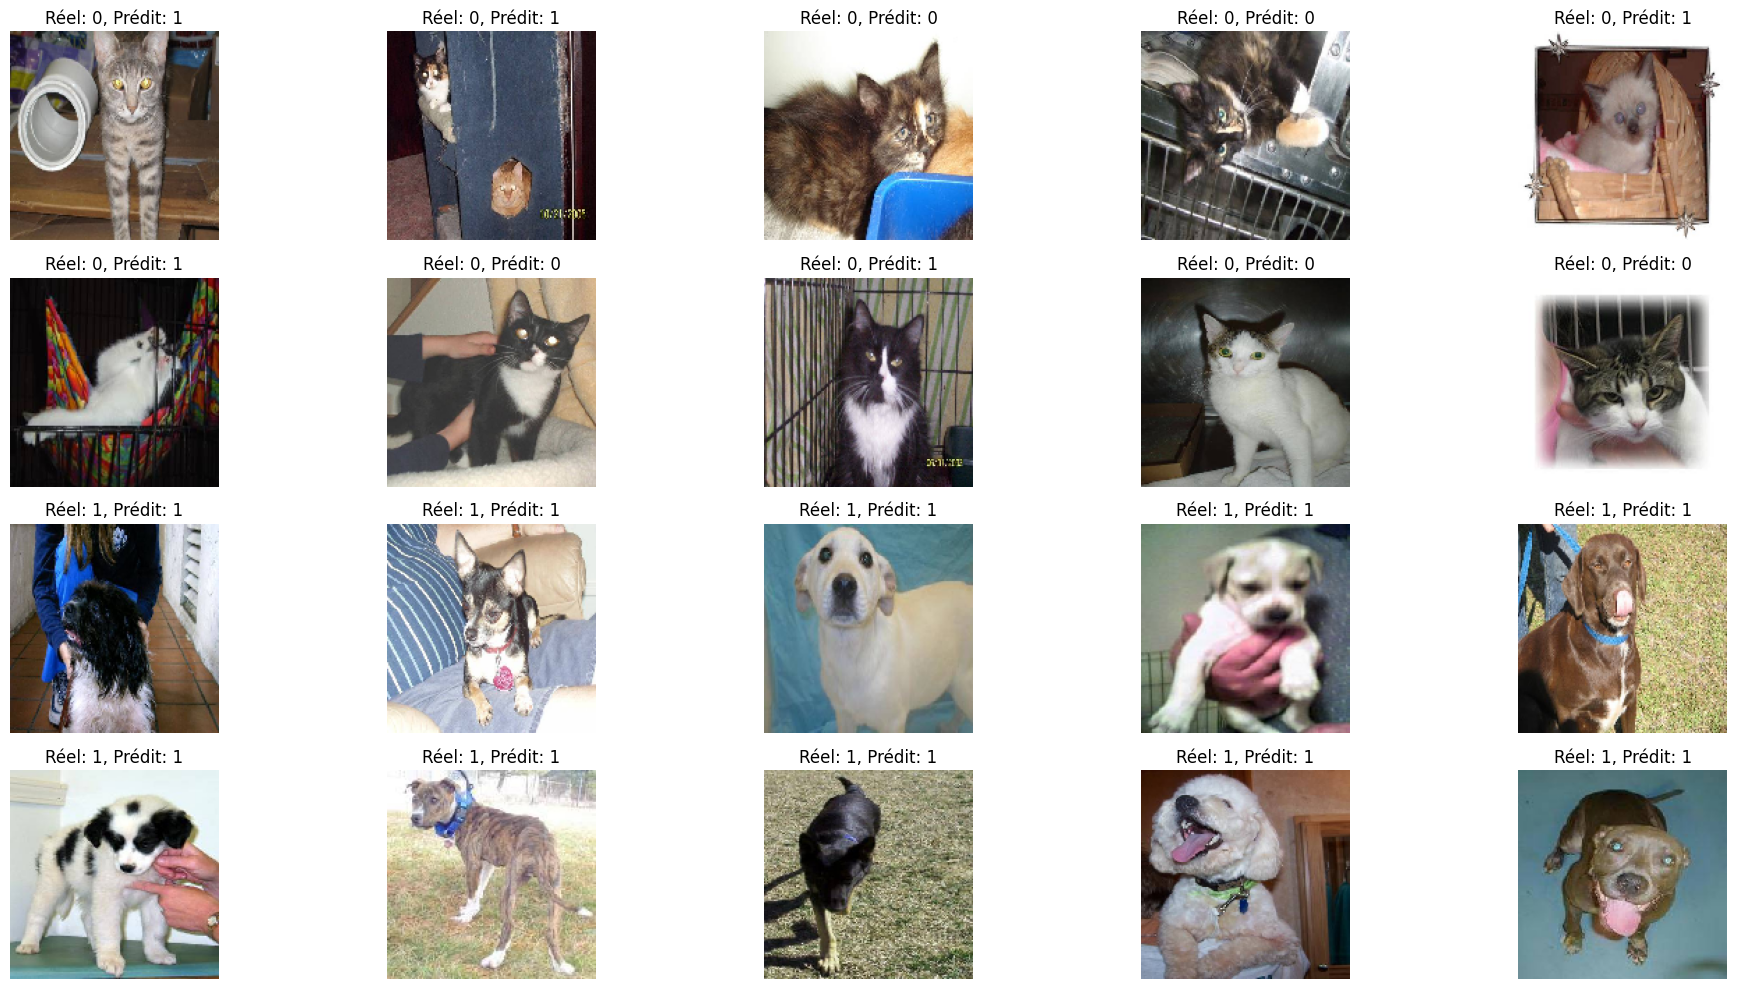

In [28]:
# Afficher les résultats pour les 20 images (10 chats et 10 chiens)
plt.figure(figsize=(20, 10))
for i, row in df_final.iterrows():
    img_path = f"/kaggle/working/train/train/{row['filename']}"
    img = load_img(img_path, target_size=(150, 150))
    plt.subplot(4, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Réel: {row['categorie']}, Prédit: {row['predictions']}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Data Augmentation

In [30]:
# Création de l'objet ImageDataGenerator avec data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalise les pixels entre 0 et 1
    rotation_range=40,          # Rotation aléatoire des images jusqu'à 40 degrés
    width_shift_range=0.2,      # Translation horizontale aléatoire jusqu'à 20% de la largeur de l'image
    height_shift_range=0.2,     # Translation verticale aléatoire jusqu'à 20% de la hauteur de l'image
    shear_range=0.2,            # Application de cisaillement
    zoom_range=0.2,             # Zoom aléatoire sur les images
    horizontal_flip=True,       # Flip horizontal des images
    fill_mode='nearest'         # Remplissage des pixels manquants après la transformation
)

In [32]:
# Sélectionner aléatoirement 1500 images de chats (catégorie 0)
chats_df = df[df['categorie'] == 0].sample(n=1500, random_state=42)

# Sélectionner aléatoirement 1500 images de chiens (catégorie 1)
chiens_df = df[df['categorie'] == 1].sample(n=1500, random_state=42)

# Combiner les deux DataFrames
df_final = pd.concat([chats_df, chiens_df]).reset_index(drop=True)
df_final


# S'assurer que la colonne 'category' contient des chaînes de caractères
df_final['categorie'] = df_final['categorie'].astype(str)

In [33]:
df_final

filename categorie
0      cat.7639.jpg         0
1      cat.1611.jpg         0
2      cat.6797.jpg         0
3     cat.12182.jpg         0
4      cat.3433.jpg         0
...             ...       ...
2995   dog.3547.jpg         1
2996  dog.11512.jpg         1
2997  dog.12054.jpg         1
2998  dog.12242.jpg         1
2999  dog.11651.jpg         1

[3000 rows x 2 columns]

In [34]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test
df_train, df_test = train_test_split(df_final, test_size=0.2, random_state=42)

# Afficher la taille des ensembles d'entraînement et de test
print(f"Taille de l'ensemble d'entraînement : {df_train.shape[0]}")
print(f"Taille de l'ensemble de test : {df_test.shape[0]}")

Taille de l'ensemble d'entraînement : 2400
Taille de l'ensemble de test : 600


In [36]:
# Chemin vers le répertoire contenant les images de chat et de chien
image_path = f'{train_dir}/cat.0.jpg'  # Exemple d'image

# Charger et prétraiter l'image
img = load_img(image_path, target_size=(150, 150))
img_array = img_to_array(img) / 255.0

In [38]:
# Fonction pour afficher l'image originale et transformée
def plot_before_and_after(original, transformed, title):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(original)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(title)
    plt.imshow(transformed)
    plt.axis('off')

    plt.show()


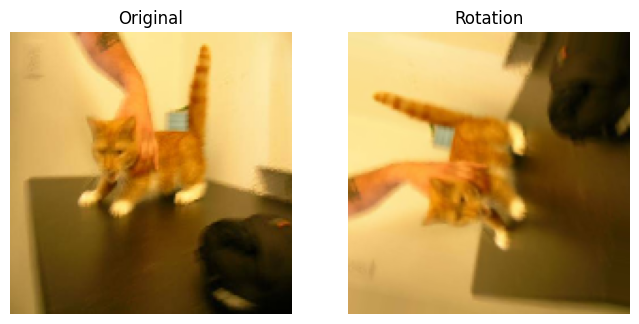

In [40]:
# Transformation de rotation
rotation_datagen = ImageDataGenerator(rotation_range=90)
rotated_img = rotation_datagen.random_transform(img_array)
plot_before_and_after(img_array, rotated_img, "Rotation")

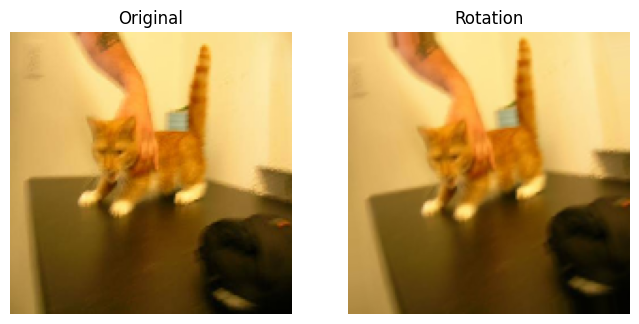

In [41]:
# Transformation de rotation
rotation_datagen = ImageDataGenerator(rotation_range=40)
rotated_img = rotation_datagen.random_transform(img_array)
plot_before_and_after(img_array, rotated_img, "Rotation")

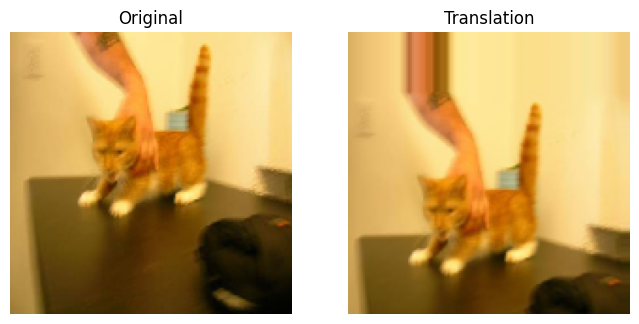

In [42]:
# Transformation de translation
translation_datagen = ImageDataGenerator(width_shift_range=0.5, height_shift_range=0.2)
translated_img = translation_datagen.random_transform(img_array)
plot_before_and_after(img_array, translated_img, "Translation")

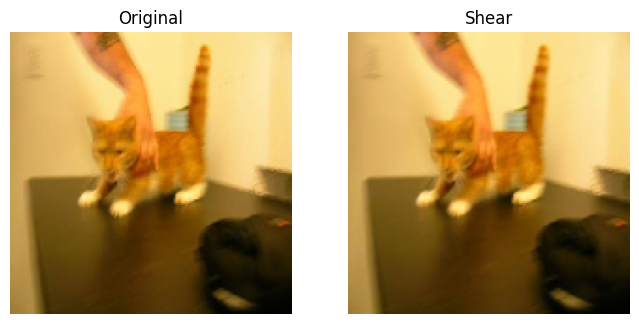

In [43]:
# Transformation de cisaillement
shear_datagen = ImageDataGenerator(shear_range=0.99)
sheared_img = shear_datagen.random_transform(img_array)
plot_before_and_after(img_array, sheared_img, "Shear")

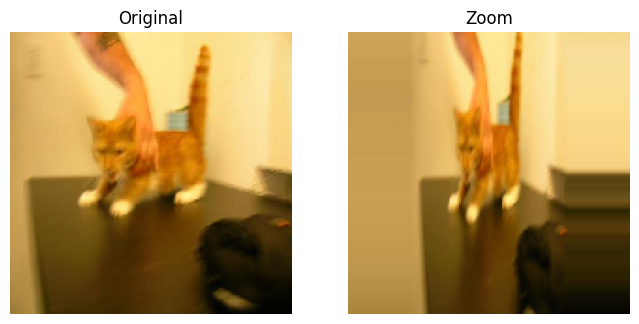

In [45]:
# Transformation de zoom
zoom_datagen = ImageDataGenerator(zoom_range=0.8)
zoomed_img = zoom_datagen.random_transform(img_array)
plot_before_and_after(img_array, zoomed_img, "Zoom")

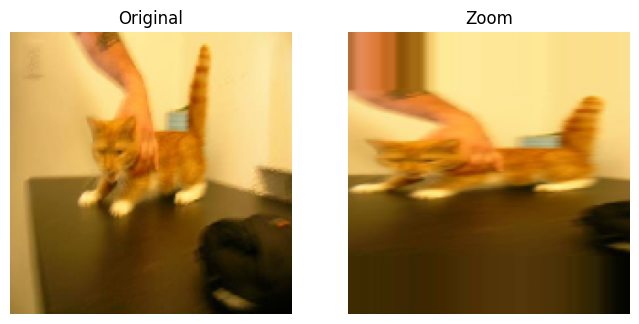

In [44]:
# Transformation de zoom
zoom_datagen = ImageDataGenerator(zoom_range=0.9)
zoomed_img = zoom_datagen.random_transform(img_array)
plot_before_and_after(img_array, zoomed_img, "Zoom")

In [46]:
# prompt: code qui définit le convnet that include dropout. Commente tout en franças j'ai déjà importé layers et models

# Définir le modèle convolutif avec dropout
model = models.Sequential()

# Couche de convolution avec 32 filtres de taille 3x3, activation ReLU et entrée de taille 150x150x3
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))

# Couche de max pooling de taille 2x2
model.add(layers.MaxPooling2D((2, 2)))

# Couche de convolution avec 64 filtres de taille 3x3 et activation ReLU
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Couche de max pooling de taille 2x2
model.add(layers.MaxPooling2D((2, 2)))

# Couche de convolution avec 128 filtres de taille 3x3 et activation ReLU
model.add(layers.Conv2D(128, (3, 3), activation='relu'))

# Couche de max pooling de taille 2x2
model.add(layers.MaxPooling2D((2, 2)))

# Couche de convolution avec 64 filtres de taille 3x3 et activation ReLU
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Couche de max pooling de taille 2x2
model.add(layers.MaxPooling2D((2, 2)))

# Couche de dropout avec un taux de 0.5 pour éviter le surapprentissage
model.add(layers.Dropout(0.5))

# Couche de flatten pour convertir les données 2D en 1D
model.add(layers.Flatten())

# Couche dense avec 512 neurones et activation ReLU
model.add(layers.Dense(512, activation='relu'))

# Couche dense avec 1 neurone et activation sigmoïde pour la classification binaire
model.add(layers.Dense(1, activation='sigmoid'))



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
# Afficher le résumé du modèle
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 15, 15, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,773,697 (6.77 MB)

 Trainable params: 1,773,697 (6.77 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [50]:
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalise les pixels entre 0 et 1
    rotation_range=40,          # Rotation aléatoire des images jusqu'à 40 degrés
    width_shift_range=0.2,      # Translation horizontale aléatoire jusqu'à 20% de la largeur de l'image
    height_shift_range=0.2,     # Translation verticale aléatoire jusqu'à 20% de la hauteur de l'image
    shear_range=0.2,            # Application de cisaillement
    zoom_range=0.2,             # Zoom aléatoire sur les images
    horizontal_flip=True,       # Flip horizontal des images
    fill_mode='nearest'         # Remplissage des pixels manquants après la transformation
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory= train_dir,
    x_col='filename',
    y_col='categorie',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 2400 validated image filenames belonging to 2 classes.


In [52]:
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalise les pixels entre 0 et 1

validation_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory= train_dir,
    x_col='filename',
    y_col='categorie',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 600 validated image filenames belonging to 2 classes.


In [53]:

# Entraînement du modèle et sauvegarde de l'historique d'entraînement dans 'history'
history = model.fit(
    train_generator,  # Utilise le générateur pour les données d'entraînement

    # Le nombre d'étapes (batches) à exécuter à chaque époque.
    # Calculé comme le nombre total d'échantillons d'entraînement divisé par la taille du lot.
    steps_per_epoch=train_generator.samples // train_generator.batch_size,

    epochs=30,  # Nombre total d'époques pour l'entraînement

    validation_data=validation_generator,  # Utilise le générateur pour les données de validation

    # Le nombre d'étapes (batches) à exécuter pour chaque époque de validation.
    # Calculé comme le nombre total d'échantillons de validation divisé par la taille du lot.
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 194ms/step - acc: 0.4884 - loss: 0.6951 - val_acc: 0.5139 - val_loss: 0.6911
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 190ms/step - acc: 0.5352 - loss: 0.6898 - val_acc: 0.5365 - val_loss: 0.6871
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 191ms/step - acc: 0.5278 - loss: 0.6909 - val_acc: 0.5347 - val_loss: 0.6847
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/step - acc: 0.5324 - loss: 0.6876 - val_acc: 0.6059 - val_loss: 0.6732
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 186ms/step - acc: 0.5551 - loss: 0.6796 - val_acc: 0.6319 - val_loss: 0.6621
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/step - acc: 0.5839 - loss: 0.6756 - val_acc: 0.5799 - val_loss: 0.6642
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 187ms/step - acc: 0.5952 - loss: 0.6641 - val_acc: 0.5972 - val_loss: 0.6557
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/step - acc: 0.5924 - loss: 0.6637 - val_acc: 0.6007 - val_loss: 0.6663
Epoch 9/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/

In [54]:
# Évaluer les performances du modèle sur la base de validation
validation_steps = validation_generator.samples // validation_generator.batch_size
evaluation = model.evaluate(validation_generator, steps=validation_steps)

# Afficher les résultats de l'évaluation
print(f"Perte sur la validation: {evaluation[0]}")
print(f"Précision sur la validation: {evaluation[1]}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - acc: 0.7449 - loss: 0.5294
Perte sur la validation: 0.5488494038581848
Précision sur la validation: 0.7152777910232544


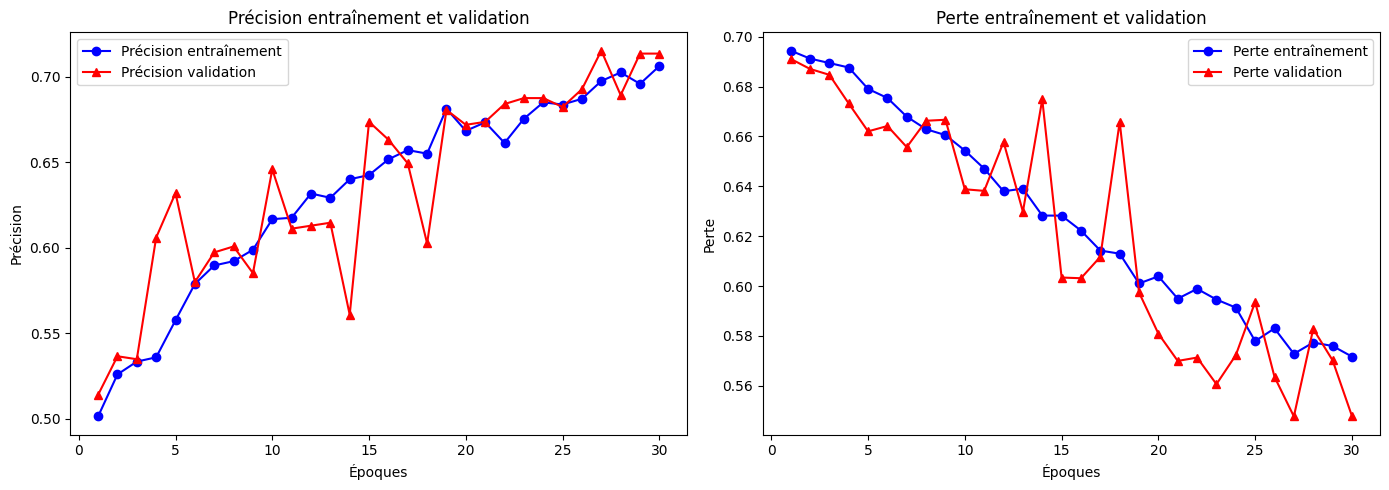

In [55]:

# Récupérer les données de l'historique
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


# Tracer la courbe de précision
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Précision entraînement')  # 'bo-' : bleu avec des points et lignes
plt.plot(epochs, val_acc, 'r^-', label='Précision validation')  # 'r^-' : rouge avec des triangles et lignes
plt.title('Précision entraînement et validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

# Tracer la courbe de perte
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Perte entraînement')  # 'bo-' : bleu avec des points et lignes
plt.plot(epochs, val_loss, 'r^-', label='Perte validation')  # 'r^-' : rouge avec des triangles et lignes
plt.title('Perte entraînement et validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.tight_layout()
plt.show()

In [57]:
from keras.utils import load_img, img_to_array


# Sélectionner aléatoirement 10 images de chats (catégorie 0)
chats_df = df[df['categorie'] == 0].sample(n=10, random_state=42)

# Sélectionner aléatoirement 10 images de chiens (catégorie 1)
chiens_df = df[df['categorie'] == 1].sample(n=10, random_state=42)

# Combiner les deux DataFrames
df_final_pred = pd.concat([chats_df, chiens_df]).reset_index(drop=True)

# S'assurer que la colonne 'category' contient des chaînes de caractères
df_final_pred['categorie'] = df_final_pred['categorie'].astype(str)
df_final_pred

filename categorie
0    cat.7639.jpg         0
1    cat.1611.jpg         0
2    cat.6797.jpg         0
3   cat.12182.jpg         0
4    cat.3433.jpg         0
5    cat.2403.jpg         0
6    cat.2000.jpg         0
7    cat.2350.jpg         0
8    cat.9476.jpg         0
9    cat.3315.jpg         0
10   dog.2142.jpg         1
11   dog.9977.jpg         1
12   dog.6998.jpg         1
13   dog.6224.jpg         1
14   dog.4055.jpg         1
15   dog.3797.jpg         1
16   dog.6902.jpg         1
17   dog.3004.jpg         1
18   dog.7714.jpg         1
19   dog.4469.jpg         1

In [59]:
# Générateur pour les données de test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    df_final_pred,
    directory=train_dir,
    x_col='filename',
    y_col='categorie',
    target_size=(150, 150),
    batch_size=10,
    class_mode='binary',
    shuffle=False  # Ne pas mélanger les données de test
)

# Faire des prédictions
predictions = model.predict(test_generator)

Found 20 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


In [60]:
# Convertir les prédictions en classes (0 ou 1)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Ajouter les prédictions au DataFrame
df_final_pred['predictions'] = predicted_classes
df_final_pred

filename categorie  predictions
0    cat.7639.jpg         0            0
1    cat.1611.jpg         0            1
2    cat.6797.jpg         0            0
3   cat.12182.jpg         0            1
4    cat.3433.jpg         0            1
5    cat.2403.jpg         0            0
6    cat.2000.jpg         0            1
7    cat.2350.jpg         0            1
8    cat.9476.jpg         0            0
9    cat.3315.jpg         0            0
10   dog.2142.jpg         1            0
11   dog.9977.jpg         1            0
12   dog.6998.jpg         1            0
13   dog.6224.jpg         1            1
14   dog.4055.jpg         1            1
15   dog.3797.jpg         1            1
16   dog.6902.jpg         1            1
17   dog.3004.jpg         1            1
18   dog.7714.jpg         1            0
19   dog.4469.jpg         1            0

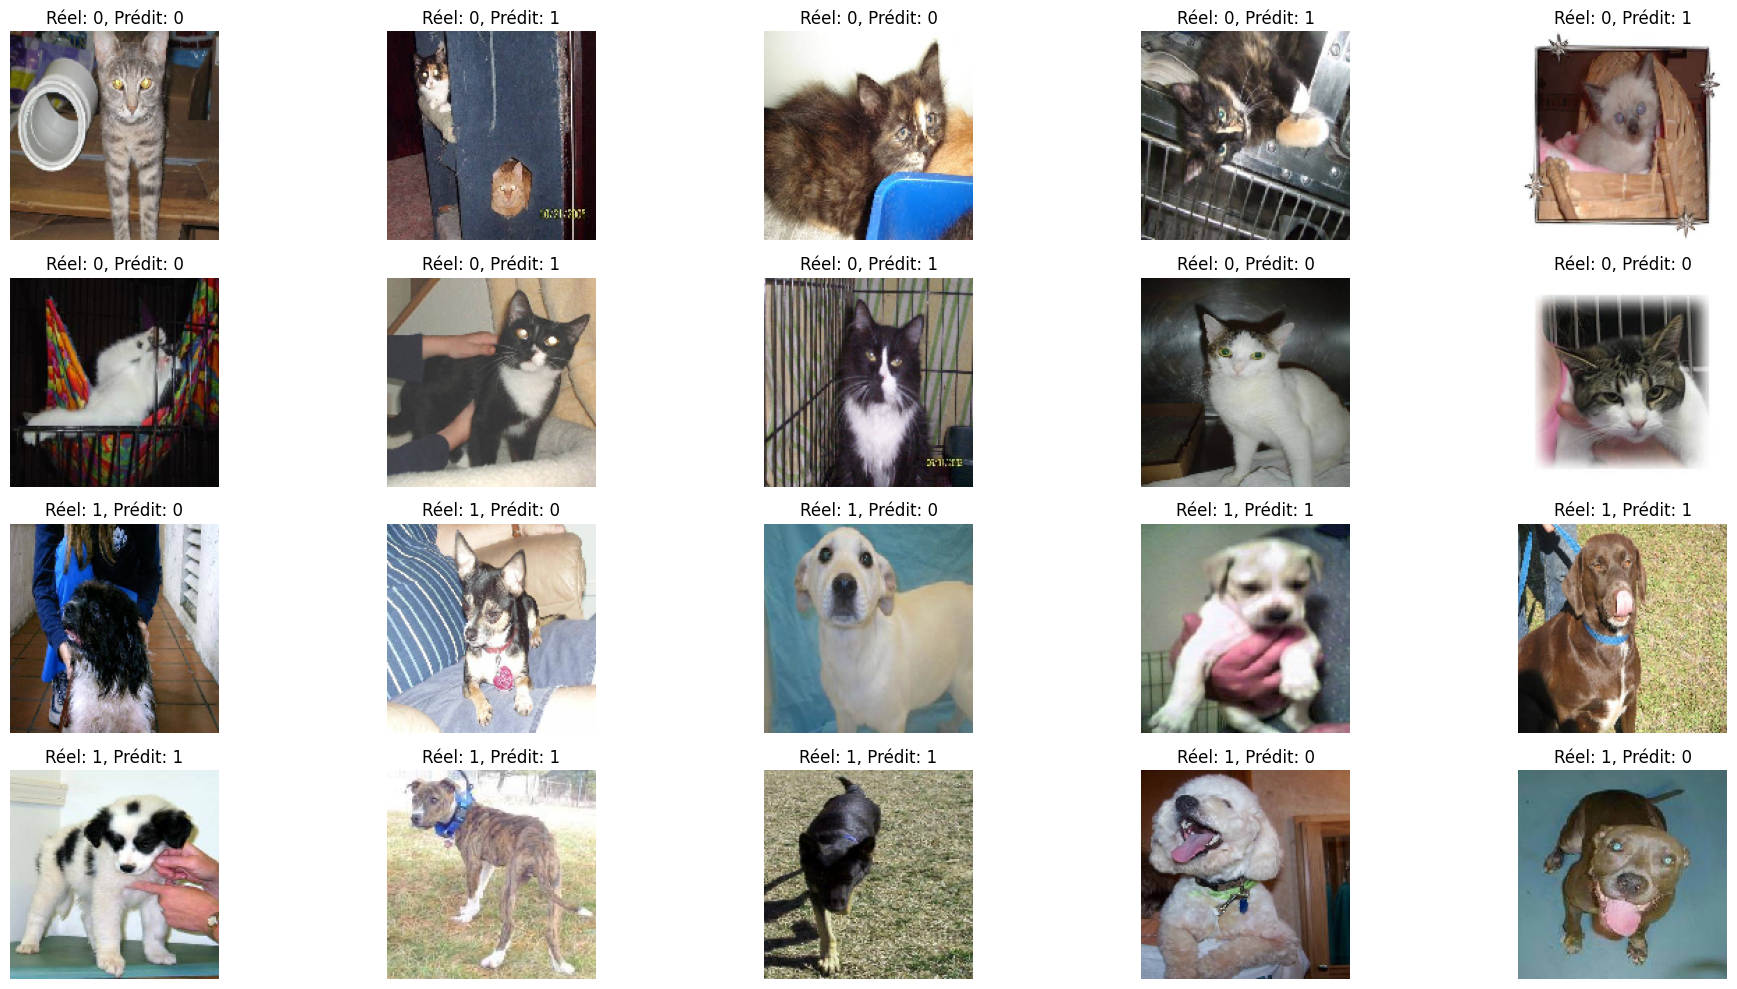

In [63]:
# Afficher les résultats pour les 20 images (10 chats et 10 chiens)
plt.figure(figsize=(20, 10))
for i, row in df_final_pred.iterrows():
    img_path = f"/kaggle/working/train/train/{row['filename']}"
    img = load_img(img_path, target_size=(150, 150))
    plt.subplot(4, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Réel: {row['categorie']}, Prédit: {row['predictions']}")
    plt.axis('off')

plt.tight_layout()
plt.show()